# Demo program  
## DNN for mnist clustering   
#### by Sting Huang

In [2]:
import tensorflow as tf
from tensorflow.python.framework import ops
from mnist_dataset import read_data_sets

ops.reset_default_graph()  #< ==== reset everything

mnist = read_data_sets('MNIST_data', one_hot=True)

SAVE = "save/dnn.ckpt"
print("\nTensorflow version:", tf.__version__)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Tensorflow version: 1.0.0-rc2


# Print training data
## topic 1, one hot encoding
## topic 2, shape

image shape: (3, 784)  output shape: (3, 10)
Label: 7 ,one hot encode => [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


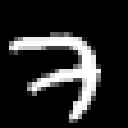

Label: 3 ,one hot encode => [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


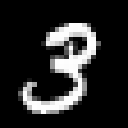

Label: 4 ,one hot encode => [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


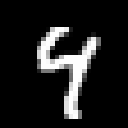

In [3]:
from IPython.core.display import display
from scipy.misc.pilutil import toimage
import numpy as np

batch_xs, batch_ys = mnist.train.next_batch(3)
print("image shape:", np.shape(batch_xs), " output shape:", np.shape(batch_ys))
for img , label in zip(batch_xs, batch_ys):
    print("Label:", np.argmax(label), ",one hot encode =>", label)
    display(toimage(img.reshape([28,28])).resize((128, 128)))  

# Build Model
## TAG1: Dropout
## TAG2: softmax

In [4]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)  # create the weight value
    return tf.Variable(initial)
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [5]:
x_ = tf.placeholder(tf.float32, [None, 784], name="x_")
y_ = tf.placeholder(tf.float32, [None, 10], name="y_")
keep_prob = tf.placeholder(tf.float32)

print("x_ shape:", tf.shape(x_))
Weight_1 = weight_variable([784, 625])
Bias_1 = bias_variable([625])
x_drop = tf.nn.dropout(x_, keep_prob)  #TAG1:dropout
FC1 = tf.nn.relu(tf.matmul(x_drop, Weight_1) + Bias_1)  #Shape 784->625
print("FC1 shape:", tf.shape(FC1))

Weight_2 = weight_variable([625, 400])
Bias_2 = bias_variable([400])
FC1_drop = tf.nn.dropout(FC1 , keep_prob)  #TAG1:dropout
FC2 = tf.nn.relu(tf.matmul(FC1_drop, Weight_2) + Bias_2)  #Shape 625->400
print("FC2 shape:", tf.shape(FC2))

Weight_3 = weight_variable([400, 256])
Bias_3 = bias_variable([256])
FC2_drop = tf.nn.dropout(FC2 , keep_prob)  #TAG1:dropout
FC3 = tf.nn.relu(tf.matmul(FC2_drop, Weight_3) + Bias_3)  #Shape 400->256
print("FC3 shape:", tf.shape(FC3))

Weight_4 = weight_variable([256, 10])
Bias_4 = bias_variable([10])
FC3_drop = tf.nn.dropout(FC3 , keep_prob)  #TAG1:dropout
y = tf.nn.softmax(tf.matmul(FC3_drop, Weight_4) + Bias_4, name= "y")  #Shape 256->10, TAG2: softmax
pred = tf.argmax(y, 1)

cross_entropy_ = tf.nn.softmax_cross_entropy_with_logits( labels=y_, logits= y, name='xentropy')
cross_entropy = tf.reduce_mean(cross_entropy_, name='xentropy_mean')

LR = 1e-3
optimizer = tf.train.AdamOptimizer(LR)
#optimizer = tf.train.GradientDescentOptimizer(LR)
trainer = optimizer.minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

x_ shape: Tensor("Shape:0", shape=(2,), dtype=int32)
FC1 shape: Tensor("Shape_1:0", shape=(2,), dtype=int32)
FC2 shape: Tensor("Shape_2:0", shape=(2,), dtype=int32)
FC3 shape: Tensor("Shape_3:0", shape=(2,), dtype=int32)


# Check result before start training

Label: 3


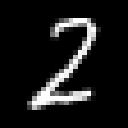

Label: 8


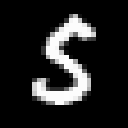

Label: 8


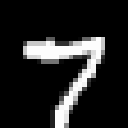

Label: 9


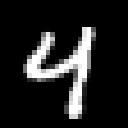

Label: 9


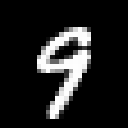

In [6]:
import random 

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

result = sess.run(pred, 
            feed_dict={x_: mnist.validation.images, y_: mnist.validation.labels, keep_prob:1})  
result_pair = zip(mnist.validation.images, result)
for img , label in random.sample(list(result_pair), 5):
    print("Label:", label)
    display(toimage(img.reshape([28,28])).resize((128, 128)))      

# Start Training
## TAG3: mini-batch

In [7]:
patience = 10
best_accurarcy = 0
echo = 0

saver = tf.train.Saver()

while True:
    echo += 1
    #Step 1, get 100 sample from training set. TAG3: mini-batch
    batch_xs, batch_ys = mnist.train.next_batch(100) 
    sess.run(trainer,  feed_dict={x_: batch_xs, y_: batch_ys, keep_prob:0.75})
    if echo%50 == 0:
        train_accurarcy, train_cost = sess.run((accuracy, cross_entropy), 
            feed_dict={x_: mnist.validation.images, y_: mnist.validation.labels, keep_prob:1})  #<== set keep prob as 1
        valid_accurarcy = sess.run(accuracy, 
            feed_dict={x_: mnist.validation.images, y_: mnist.validation.labels, keep_prob:1})  
        print( "{0}, cost:{1:.3f}, train accurarcy:{2:.3f}, valid accurarcy:{3:.3f}, patience:{4}".format(echo, train_cost, train_accurarcy, valid_accurarcy, patience))
        if valid_accurarcy > best_accurarcy:
            patience = 15
            best_accurarcy = valid_accurarcy
            print("save model:", saver.save(sess, SAVE))
        else:
            patience -= 1
            if patience == 0:
                print( "early stop")
                break

50, cost:1.779, train accurarcy:0.686, valid accurarcy:0.686, patience:10
save model: save/dnn.ckpt
100, cost:1.653, train accurarcy:0.809, valid accurarcy:0.809, patience:15
save model: save/dnn.ckpt
150, cost:1.626, train accurarcy:0.835, valid accurarcy:0.835, patience:15
save model: save/dnn.ckpt
200, cost:1.583, train accurarcy:0.879, valid accurarcy:0.879, patience:15
save model: save/dnn.ckpt
250, cost:1.559, train accurarcy:0.903, valid accurarcy:0.903, patience:15
save model: save/dnn.ckpt
300, cost:1.554, train accurarcy:0.908, valid accurarcy:0.908, patience:15
save model: save/dnn.ckpt
350, cost:1.541, train accurarcy:0.921, valid accurarcy:0.921, patience:15
save model: save/dnn.ckpt
400, cost:1.537, train accurarcy:0.925, valid accurarcy:0.925, patience:15
save model: save/dnn.ckpt
450, cost:1.528, train accurarcy:0.934, valid accurarcy:0.934, patience:15
save model: save/dnn.ckpt
500, cost:1.534, train accurarcy:0.927, valid accurarcy:0.927, patience:15
550, cost:1.538, 

Label: 9


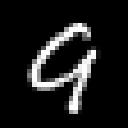

Label: 6


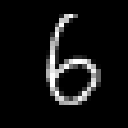

Label: 7


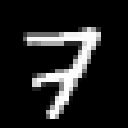

Label: 6


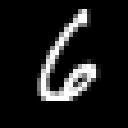

Label: 4


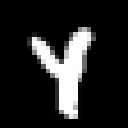

In [8]:
import random
saver.restore(sess, SAVE) #restore the best module
result = sess.run(pred, 
            feed_dict={x_: mnist.validation.images, y_: mnist.validation.labels, keep_prob:1})  
result_pair = zip(mnist.validation.images, result)
for img , label in random.sample(list(result_pair), 5):
    print("Label:", label)
    display(toimage(img.reshape([28,28])).resize((128, 128)))      

Label: 6


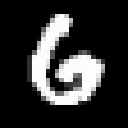

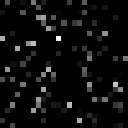

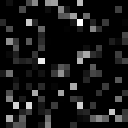

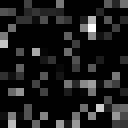

Label: 4


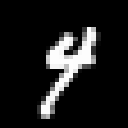

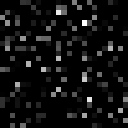

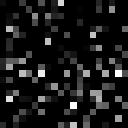

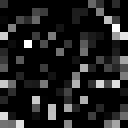

Label: 2


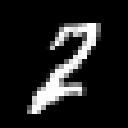

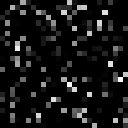

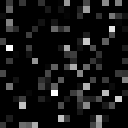

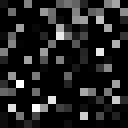

Label: 1


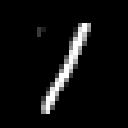

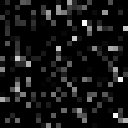

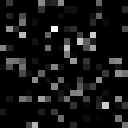

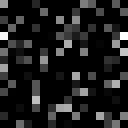

Label: 0


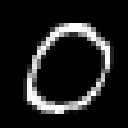

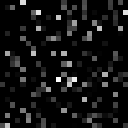

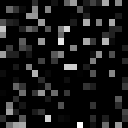

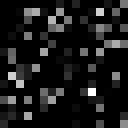

In [10]:
import random 
result,  fc1, fc2, fc3= sess.run((pred, FC1, FC2, FC3), 
            feed_dict={x_: mnist.validation.images, y_: mnist.validation.labels, keep_prob:1})  
result_pair = zip(mnist.validation.images, result,  fc1, fc2, fc3)
for img , label, img_fc1, img_fc2, img_fc3 in random.sample(list(result_pair), 5):
    print("Label:", label)
    display(toimage(img.reshape([28,28])).resize((128, 128)))      
    display(toimage(img_fc1.reshape([25,25])).resize((128, 128)))      
    display(toimage(img_fc2.reshape([20,20])).resize((128, 128)))      
    display(toimage(img_fc3.reshape([16,16])).resize((128, 128)))      